<a href="https://colab.research.google.com/github/awun0105/Detecting_COVID19_From_Chest_XRay_Images_Using_Pytorch/blob/master/Detecting_COVID19_From_Chest_XRay_Images_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Detecting COVID-19 with Chest X Ray using PyTorch
Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset downloaded from [COVID-19 Radiography Dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database) on Kaggle
By: Lam Quang Anh Quan

Github: https://github.com/awun0105/Detecting_COVID19_From_Chest_XRay_Images_Using_Pytorch.git

Feel free to walkthrough and use it


#__1.__ Download dataset from google drive
I downloaded the dataset from Kaggle and uploaded it to Google Drive for easy access.



In [ ]:
#https://drive.google.com/file/d/1a6we4fbu2SF8NrlAjDRLGsxgkJCJzM5s/view?usp=sharing
!gdown '1a6we4fbu2SF8NrlAjDRLGsxgkJCJzM5s'

Downloading...
From (original): https://drive.google.com/uc?id=1a6we4fbu2SF8NrlAjDRLGsxgkJCJzM5s
From (redirected): https://drive.google.com/uc?id=1a6we4fbu2SF8NrlAjDRLGsxgkJCJzM5s&confirm=t&uuid=767e7e54-d81c-408a-9114-364c40f733fc
To: /content/COVID-19 Radiography Database.zip
100% 816M/816M [00:16<00:00, 48.1MB/s]


#__2.__ Unzip dataset

In [ ]:
!unzip -q '/content/COVID-19 Radiography Database.zip' -d '/content/COVID-19_Radiography_Dataset'

#__3.__ inspecting the directory:
This code helps visualize the contents of a directory, displaying the hierarchy and up to 5 files in each folder to keep the output manageable.

but you can see in the output that the folder is messed up, it is nested so we need to move the entire contents of a nested folder to the main folder and removes the now-empty nested folder in the next code cell


In [ ]:
import shutil
import os
def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Print only first 5 files to keep output manageable
            print('{}{}'.format(subindent, f))
        if len(files) > 5:
            print('{}...'.format(subindent))

print_directory_structure('/content/COVID-19_Radiography_Dataset')



COVID-19_Radiography_Dataset/
    COVID-19_Radiography_Dataset/
        Normal.metadata.xlsx
        README.md.txt
        COVID.metadata.xlsx
        Viral Pneumonia.metadata.xlsx
        Lung_Opacity.metadata.xlsx
        Normal/
            masks/
                Normal-266.png
                Normal-7913.png
                Normal-5312.png
                Normal-2389.png
                Normal-4126.png
                ...
            images/
                Normal-266.png
                Normal-7913.png
                Normal-5312.png
                Normal-2389.png
                Normal-4126.png
                ...
        Lung_Opacity/
            masks/
                Lung_Opacity-919.png
                Lung_Opacity-1776.png
                Lung_Opacity-5147.png
                Lung_Opacity-6001.png
                Lung_Opacity-3782.png
                ...
            images/
                Lung_Opacity-919.png
                Lung_Opacity-1776.png
                Lung_Opaci

This code is useful when you need to flatten a nested directory structure, moving all contents up one level to the main directory and cleaning up the empty folder left behind.

In [ ]:
# Move all contents from the nested folder to the main folder
src_dir = "/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"
dest_dir = "/content/COVID-19_Radiography_Dataset"

# Move the files
for item in os.listdir(src_dir):
    s = os.path.join(src_dir, item)
    d = os.path.join(dest_dir, item)
    if os.path.isdir(s):
        shutil.move(s, d)
    else:
        shutil.move(s, d)

# Remove the empty nested folder if no data remains
os.rmdir(src_dir)

# Check the directory structure after moving
print("Updated directory structure:")
print_directory_structure('/content/COVID-19_Radiography_Dataset')


Updated directory structure:
COVID-19_Radiography_Dataset/
    Normal.metadata.xlsx
    README.md.txt
    COVID.metadata.xlsx
    Viral Pneumonia.metadata.xlsx
    Lung_Opacity.metadata.xlsx
    Normal/
        masks/
            Normal-266.png
            Normal-7913.png
            Normal-5312.png
            Normal-2389.png
            Normal-4126.png
            ...
        images/
            Normal-266.png
            Normal-7913.png
            Normal-5312.png
            Normal-2389.png
            Normal-4126.png
            ...
    Lung_Opacity/
        masks/
            Lung_Opacity-919.png
            Lung_Opacity-1776.png
            Lung_Opacity-5147.png
            Lung_Opacity-6001.png
            Lung_Opacity-3782.png
            ...
        images/
            Lung_Opacity-919.png
            Lung_Opacity-1776.png
            Lung_Opacity-5147.png
            Lung_Opacity-6001.png
            Lung_Opacity-3782.png
            ...
    Viral Pneumonia/
        masks/
 

#__4.__ Importing Libraries

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.4.0+cu121


In [ ]:
# Check and set up the device (use GPU if available; otherwise, use CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#__5.__ Preparing Training and Test Sets

This step involves organizing the dataset into training and test sets. The code first sets up the directory structure by checking the existence of the source directories and creating a test folder if needed. It then renames the source directories to match the class names and moves the images from nested 'images' subfolders to their respective class folders. After setting up the main class folders, subdirectories for each class are created within the test folder. Finally, the code randomly selects up to 30 images from each class and moves them to the corresponding class subdirectory in the test set, allowing for a balanced test sample for model evaluation.

In [ ]:
import os
import random
import shutil

class_names = ['normal', 'viral', 'covid']
root_dir = '/content/COVID-19_Radiography_Dataset/'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']  # Ensure these match the original folder names

# Print the current directory structure
print("Current directory structure:")
print(os.listdir(root_dir))

# Check and prepare the test directory if needed
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    # Create the test directory if it does not exist
    test_dir = os.path.join(root_dir, 'test')
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)

    # Rename source directories to match class_names
    for i, d in enumerate(source_dirs):
        src_dir = os.path.join(root_dir, d)
        dst_dir = os.path.join(root_dir, class_names[i])
        os.rename(src_dir, dst_dir)

        # Move images from the 'images' subfolder to the parent class folder
        images_path = os.path.join(dst_dir, 'images')
        if os.path.exists(images_path):
            for img in os.listdir(images_path):
                shutil.move(os.path.join(images_path, img), dst_dir)
            # Remove the 'images' folder if it's empty
            if not os.listdir(images_path):
                os.rmdir(images_path)

    # Create subdirectories for each class inside the test directory
    for c in class_names:
        test_class_dir = os.path.join(root_dir, 'test', c)
        if not os.path.exists(test_class_dir):
            os.mkdir(test_class_dir)

    # Randomly move images from each class folder to the test directory
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        num_images_to_sample = min(30, len(images))  # Select up to 30 images or fewer if not enough
        selected_images = random.sample(images, num_images_to_sample)
        print(f"Moving {len(selected_images)} images from {c} to test/{c}")
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)


Current directory structure:
['Normal.metadata.xlsx', 'README.md.txt', 'Normal', 'Lung_Opacity', 'COVID.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'Viral Pneumonia', 'COVID']
Moving 30 images from normal to test/normal
Moving 30 images from viral to test/viral
Moving 30 images from covid to test/covid



Check the number of images in the folders after moving.

In [ ]:
# Check the number of images in the test folder after moving.
print("\nChecking directories after moving images:")
for c in class_names:
    test_count = len([x for x in os.listdir(os.path.join(root_dir, 'test', c)) if x.lower().endswith('png')])
    print(f"{c}: {test_count} images in test.")



Checking directories after moving images:
normal: 30 images in test.
viral: 30 images in test.
covid: 30 images in test.


#__6.__ Creating Custom Dataset

This code defines a custom dataset class called ChestXRayDataset for handling chest X-ray images using PyTorch. The dataset is prepared to work seamlessly with PyTorch's DataLoader, making it super easy to use in your deep learning pipelines.

This setup allows us to dynamically pull images from different classes, handle missing folders gracefully, and prepare our data efficiently for model training. It's flexible, and the use of transform ensures that our images are pre-processed just the way we want before feeding them into a neural network.

In [ ]:
from PIL import Image
import torch
import os
import random

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            dir_path = image_dirs[class_name]
            if not os.path.exists(dir_path):
                print(f"Warning: Directory not found for {class_name}: {dir_path}")
                return []

            # Kiểm tra thư mục images; nếu không tồn tại, dùng thư mục chính
            images_path = os.path.join(dir_path, 'images')
            if not os.path.exists(images_path):
                images_path = dir_path  # Nếu không có 'images', sử dụng thư mục chính

            images = [x for x in os.listdir(images_path) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images, images_path

        self.images = {}
        self.image_paths = {}
        self.class_names = ['normal', 'viral', 'covid']

        for c in self.class_names:
            self.images[c], self.image_paths[c] = get_images(c)

        self.transform = transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        available_classes = [c for c in self.class_names if len(self.images[c]) > 0]
        if not available_classes:
            raise ValueError("No images found in any class directories.")

        class_name = random.choice(available_classes)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_paths[class_name], image_name)
        image = Image.open(image_path).convert('RGB')

        return self.transform(image), self.class_names.index(class_name)


#__7.__ Image Transformations

This part is all about preparing our images before they go into the neural network, ensuring they are in the right format, size, and standardized for training and testing.

These transformations help standardize the input data, augment the training set to prevent overfitting, and ensure our model receives images in the best possible format for learning and evaluation. By resizing, flipping, and normalizing, we're setting up our data to be as effective as possible when fed into the neural network!

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#__8.__ Prepare DataLoader
In this step, we're setting up the paths to our training data and ensuring everything is correctly linked so the dataset can be used without errors.

Before creating the data loaders, verifying the paths prevents runtime errors related to missing files or incorrect directory structures. This preparation step makes sure that when we pass these directories to our custom dataset class, it can successfully find and load the images without any surprises!

In [ ]:
# Set the correct paths based on your directory structure
train_dirs = {
    'normal': os.path.join(root_dir, 'normal'),  # Ensure the folder name is correct
    'viral': os.path.join(root_dir, 'viral'),
    'covid': os.path.join(root_dir, 'covid')  # Adjust the path to be accurate
}

# Check the directory structure to ensure these paths are correct
print("Directory check:")
for key, path in train_dirs.items():
    print(f"{key}: {path}, Exists: {os.path.exists(path)}")

Directory check:
normal: /content/COVID-19_Radiography_Dataset/normal, Exists: True
viral: /content/COVID-19_Radiography_Dataset/viral, Exists: True
covid: /content/COVID-19_Radiography_Dataset/covid, Exists: True


In [ ]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [ ]:
print_directory_structure('/content/COVID-19_Radiography_Dataset')

COVID-19_Radiography_Dataset/
    Normal.metadata.xlsx
    README.md.txt
    COVID.metadata.xlsx
    Viral Pneumonia.metadata.xlsx
    Lung_Opacity.metadata.xlsx
    test/
        covid/
            COVID-452.png
            COVID-2922.png
            COVID-891.png
            COVID-1447.png
            COVID-1502.png
            ...
        normal/
            Normal-1185.png
            Normal-3678.png
            Normal-2948.png
            Normal-3526.png
            Normal-5806.png
            ...
        viral/
            Viral Pneumonia-1306.png
            Viral Pneumonia-1102.png
            Viral Pneumonia-820.png
            Viral Pneumonia-474.png
            Viral Pneumonia-236.png
            ...
    Lung_Opacity/
        masks/
            Lung_Opacity-919.png
            Lung_Opacity-1776.png
            Lung_Opacity-5147.png
            Lung_Opacity-6001.png
            Lung_Opacity-3782.png
            ...
        images/
            Lung_Opacity-919.png
            

In [ ]:
# Redefine paths for test_dirs, ensuring they match the actual structure
test_dirs = {
    'normal': os.path.join(root_dir, 'test', 'normal'),
    'viral': os.path.join(root_dir, 'test', 'viral'),
    'covid': os.path.join(root_dir, 'test', 'covid')  # Adjust the folder name if necessary
}

# Check the paths
print("Test directory check:")
for key, path in test_dirs.items():
    print(f"{key}: {path}, Exists: {os.path.exists(path)}")


Test directory check:
normal: /content/COVID-19_Radiography_Dataset/test/normal, Exists: True
viral: /content/COVID-19_Radiography_Dataset/test/viral, Exists: True
covid: /content/COVID-19_Radiography_Dataset/test/covid, Exists: True


In [ ]:
# Create dataset for test folder
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
# Print number of images in each directory
for c in class_names:
    print(f"{c}:")
    print(f"  Train: {len(os.listdir(train_dirs[c]))} images")
    print(f"  Test: {len(os.listdir(test_dirs[c]))} images")
print_directory_structure('/content/COVID-19_Radiography_Dataset')

normal:
  Train: 10163 images
  Test: 30 images
viral:
  Train: 1316 images
  Test: 30 images
covid:
  Train: 3587 images
  Test: 30 images
COVID-19_Radiography_Dataset/
    Normal.metadata.xlsx
    README.md.txt
    COVID.metadata.xlsx
    Viral Pneumonia.metadata.xlsx
    Lung_Opacity.metadata.xlsx
    test/
        covid/
            COVID-452.png
            COVID-2922.png
            COVID-891.png
            COVID-1447.png
            COVID-1502.png
            ...
        normal/
            Normal-1185.png
            Normal-3678.png
            Normal-2948.png
            Normal-3526.png
            Normal-5806.png
            ...
        viral/
            Viral Pneumonia-1306.png
            Viral Pneumonia-1102.png
            Viral Pneumonia-820.png
            Viral Pneumonia-474.png
            Viral Pneumonia-236.png
            ...
    Lung_Opacity/
        masks/
            Lung_Opacity-919.png
            Lung_Opacity-1776.png
            Lung_Opacity-5147.png
     


tạo các batch dữ liệu từ train_dataset và test_dataset

In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2511
Number of test batches 15


#__9.__ Data Visualization


In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 8))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.rc('axes', labelsize=14)
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

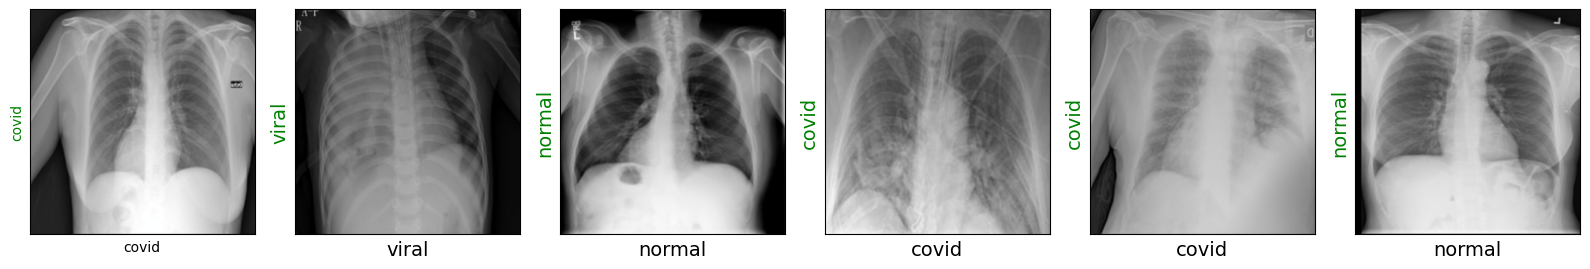

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)


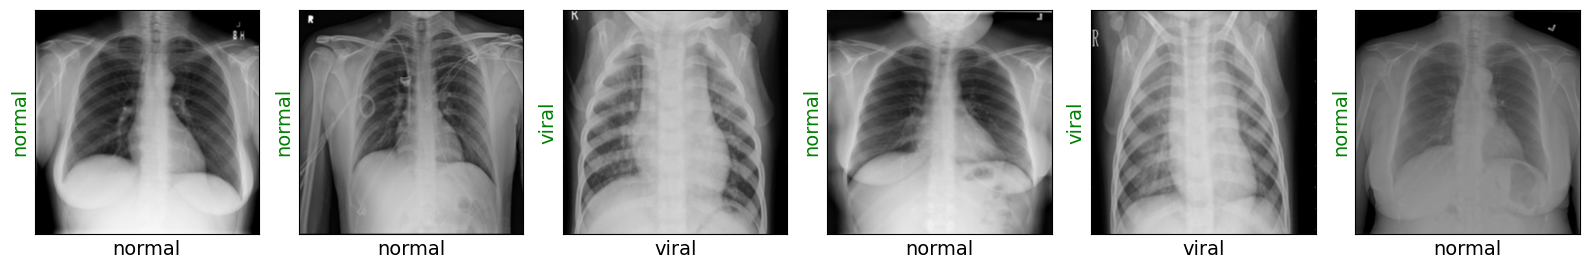

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

#__10.__ Creating the Model

In [ ]:
!pip install torchinfo

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
resnet18 = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
from torchinfo import summary
# Print detailed information about the model
print(summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           --                        True
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           [1, 64, 56, 56]           --                        True
│    │ 

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Adjust classification layer to problem at hand qwith 3 output classes
model.fc = torch.nn.Linear(in_features=512, out_features=3)
model = model.to(device)

# Define loss function and Optimizer. Select all model parameters to be fined-tuned
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def show_preds():
    model.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

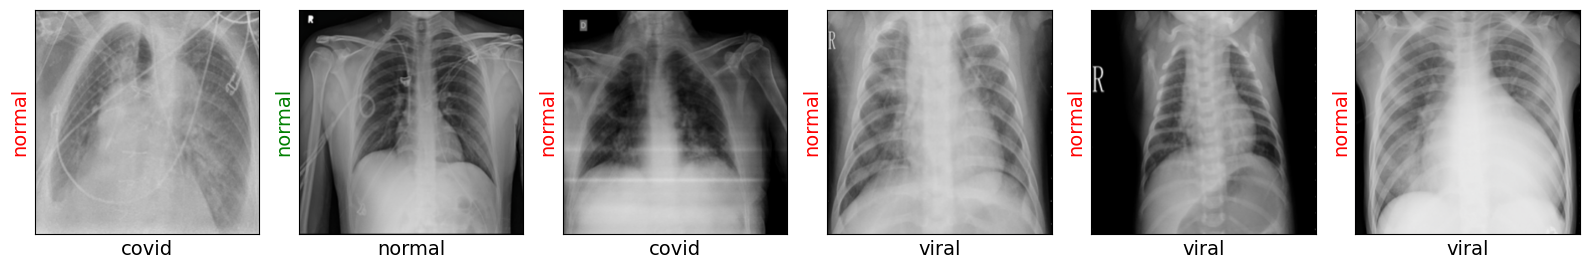

calculating model accuracy before training (should be 1/3 for 3 classes)....
Accuracy of un-trained model: 0.2667


In [ ]:
show_preds()
print('calculating model accuracy before training (should be 1/3 for 3 classes)....')
accuracy = 0
# Evaluate accuracy of non-trained model
model.eval()
for val_step, (images, labels) in enumerate(dl_test):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    accuracy += sum((preds == labels).cpu().numpy())
accuracy = accuracy / len(test_dataset)
print(f'Accuracy of un-trained model: {accuracy:.4f}')

#__11.__ Training the Model


In [ ]:
import time
def train(epochs):

    print('Start training..')

    start_time = time.time()
    running_train_loss = []
    running_val_loss = []

    for epoch in range(epochs):

        print('='*20)
        print(f'Starting epoch {epoch + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):

            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0
                model.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):

                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                current_time = time.time()

                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f} Training time: {(current_time-start_time)//60:.0f} minutes')

                show_preds()

                running_val_loss.append(val_loss)

                model.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')

                    # Create folder ./models if not exists
                    save_dir = './models'
                    if not os.path.exists(save_dir):
                      os.makedirs(save_dir)

                    save_file = os.path.join(save_dir, 'resnet18.pt')
                    torch.save(model.state_dict(), save_file)
                    print(f"Model saved to {save_file}")
                    return running_train_loss, running_val_loss

            train_loss /= (train_step + 1)
            running_train_loss.append(train_loss)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Start training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.3969, Accuracy: 0.2556 Training time: 0 minutes


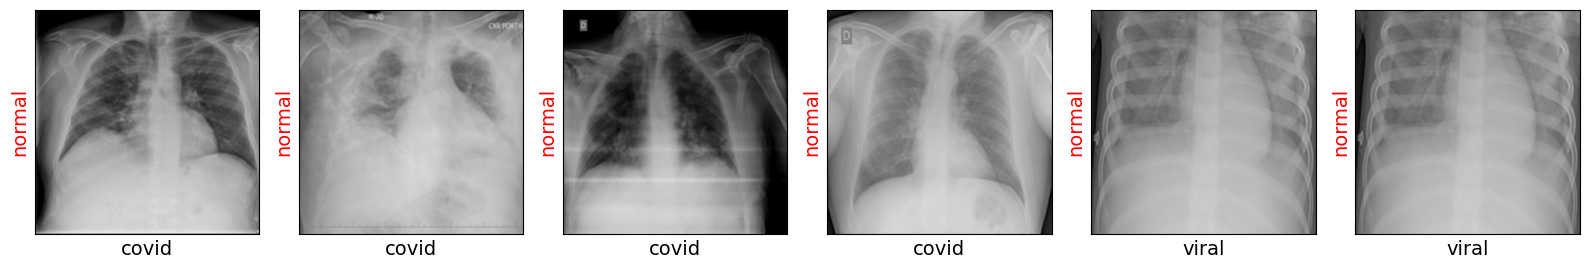

Evaluating at step 20
Validation Loss: 0.9239, Accuracy: 0.5556 Training time: 0 minutes


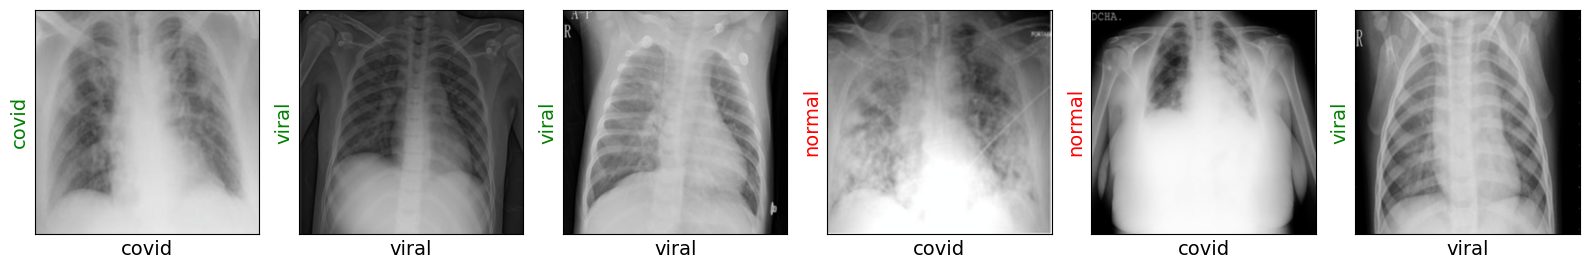

Evaluating at step 40
Validation Loss: 0.4822, Accuracy: 0.8889 Training time: 0 minutes


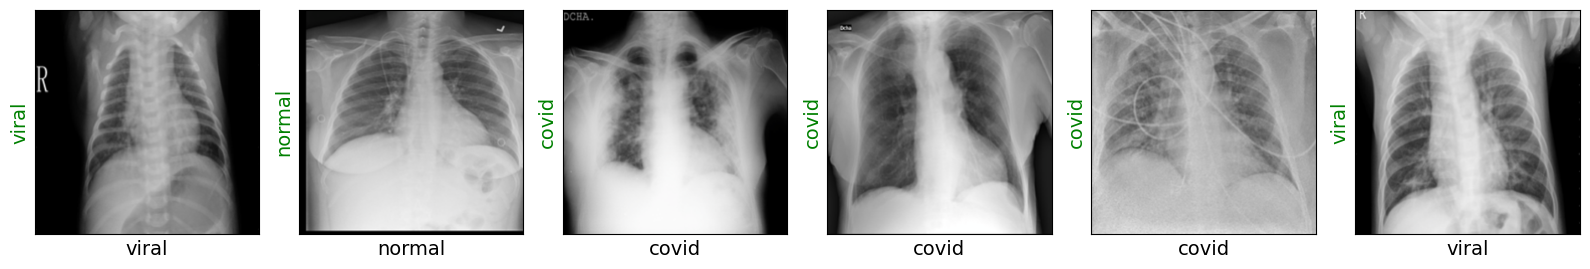

Evaluating at step 60
Validation Loss: 0.3482, Accuracy: 0.9222 Training time: 0 minutes


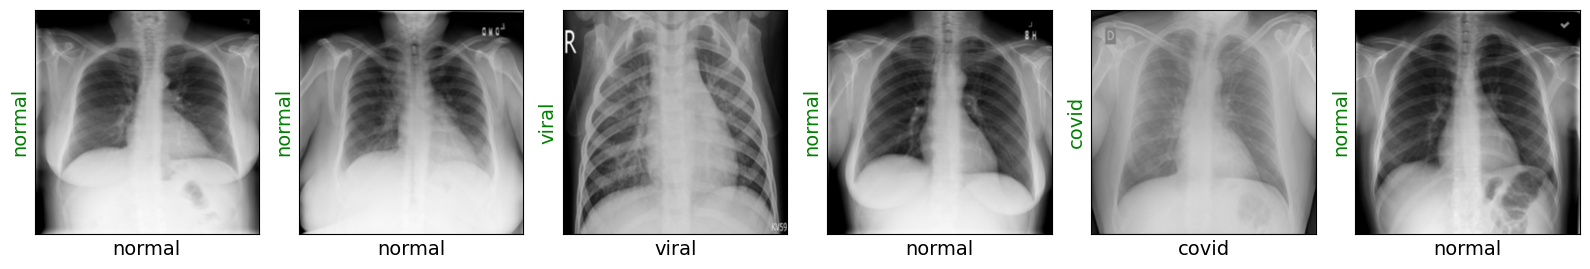

Evaluating at step 80
Validation Loss: 0.2504, Accuracy: 0.9333 Training time: 0 minutes


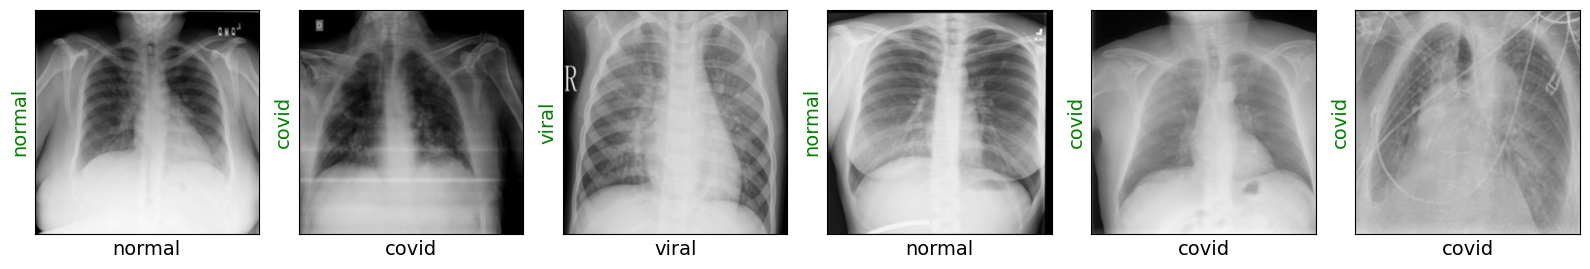

Evaluating at step 100
Validation Loss: 0.2270, Accuracy: 0.9222 Training time: 0 minutes


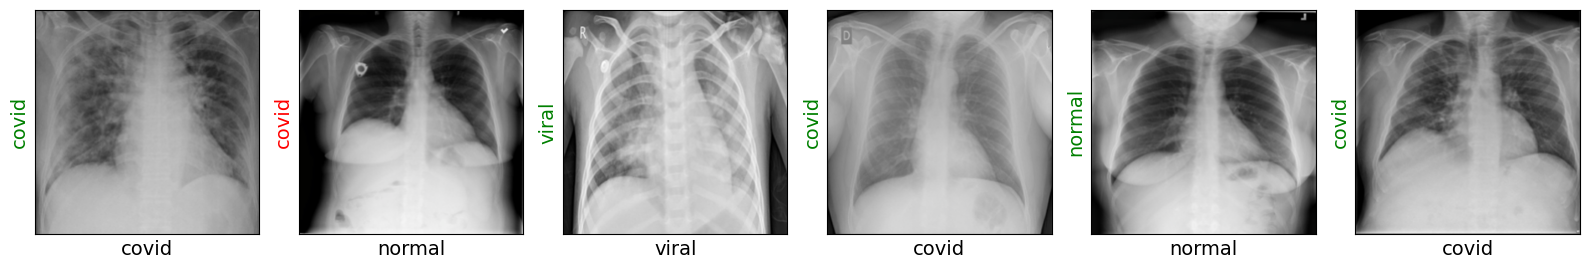

Evaluating at step 120
Validation Loss: 0.2204, Accuracy: 0.9444 Training time: 0 minutes


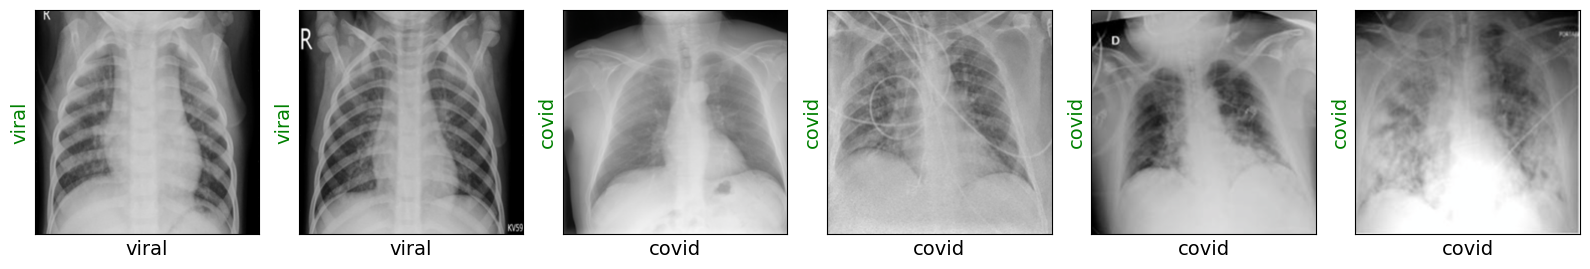

Evaluating at step 140
Validation Loss: 0.2225, Accuracy: 0.9222 Training time: 0 minutes


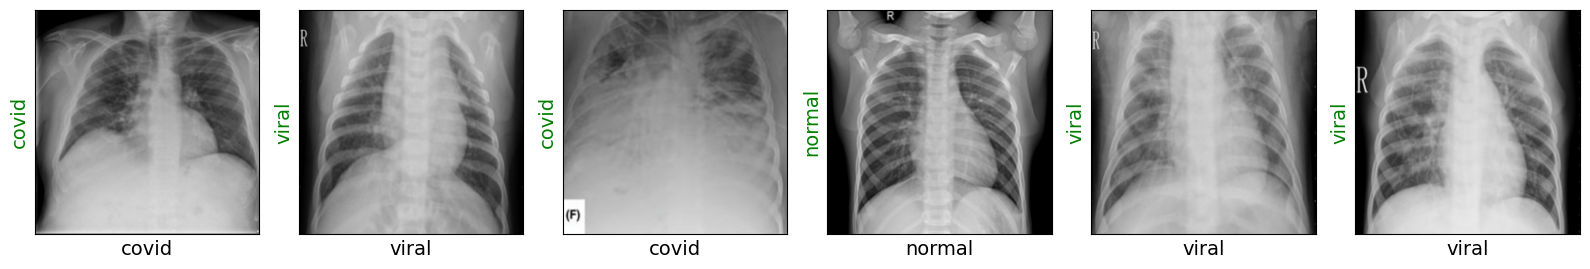

Evaluating at step 160
Validation Loss: 0.1584, Accuracy: 0.9667 Training time: 0 minutes


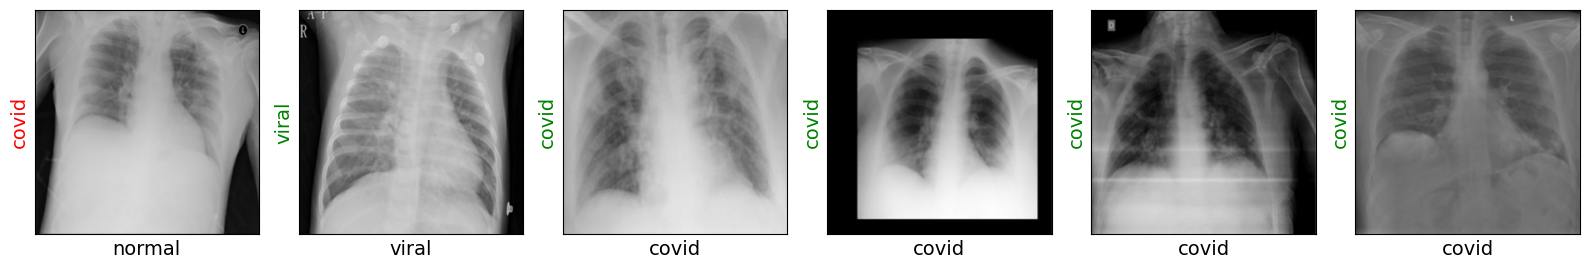

Evaluating at step 180
Validation Loss: 0.1732, Accuracy: 0.9667 Training time: 0 minutes


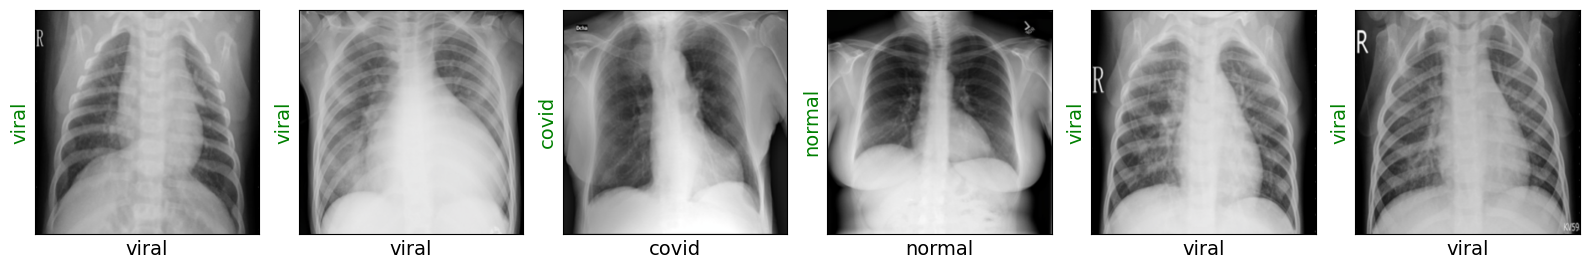

Evaluating at step 200
Validation Loss: 0.1686, Accuracy: 0.9556 Training time: 0 minutes


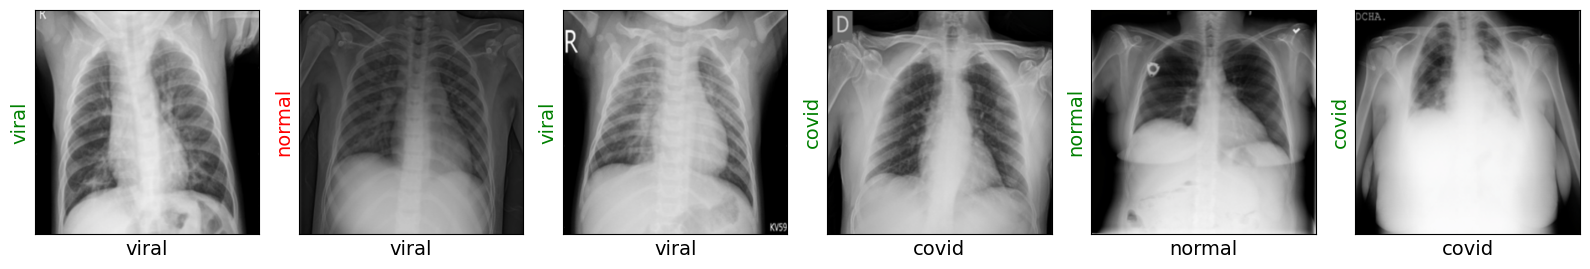

Evaluating at step 220
Validation Loss: 0.1554, Accuracy: 0.9556 Training time: 0 minutes


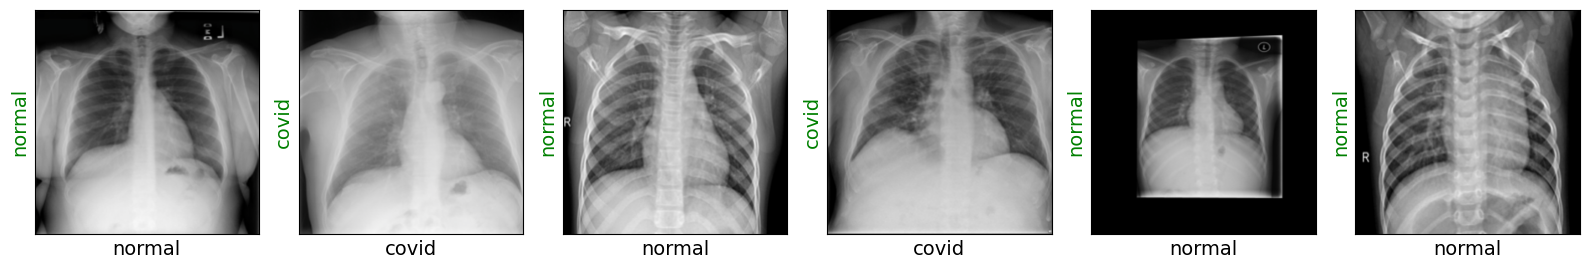

Evaluating at step 240
Validation Loss: 0.1223, Accuracy: 0.9667 Training time: 0 minutes


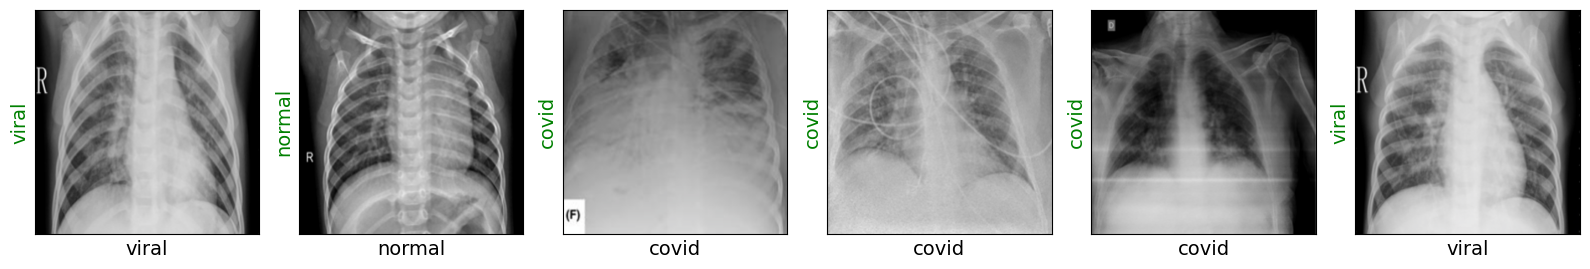

Evaluating at step 260
Validation Loss: 0.2128, Accuracy: 0.9333 Training time: 0 minutes


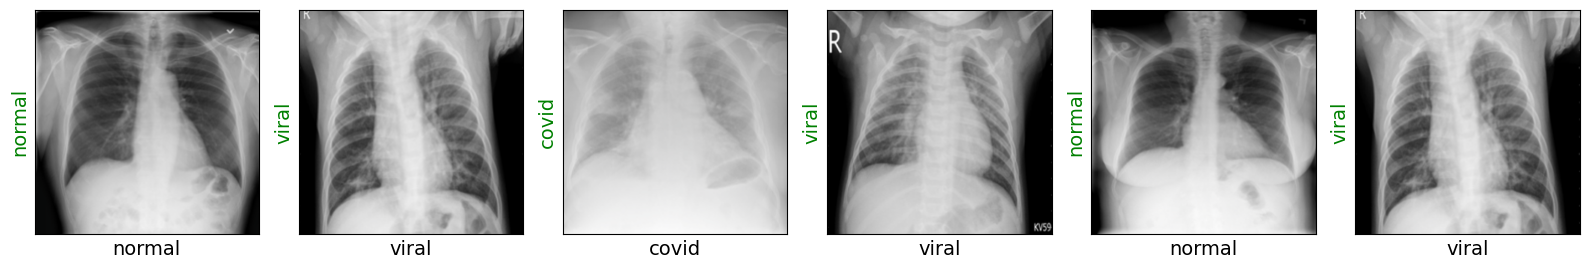

Evaluating at step 280
Validation Loss: 0.1097, Accuracy: 0.9889 Training time: 0 minutes


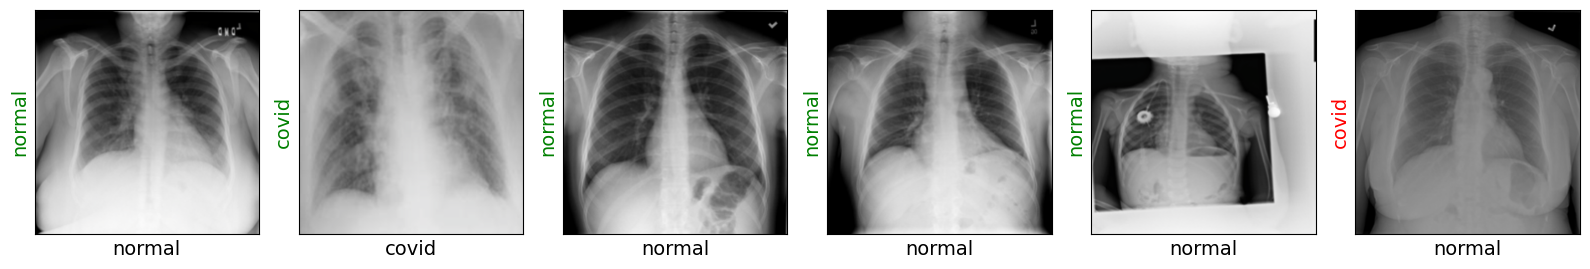

Performance condition satisfied, stopping..
Model saved to ./models/resnet18.pt
CPU times: user 31 s, sys: 2.69 s, total: 33.7 s
Wall time: 40 s


In [ ]:
%%time
running_train_loss, running_val_loss = train(epochs=1)

This code visualizes the training and validation loss over time, helping us understand how well the model is learning.

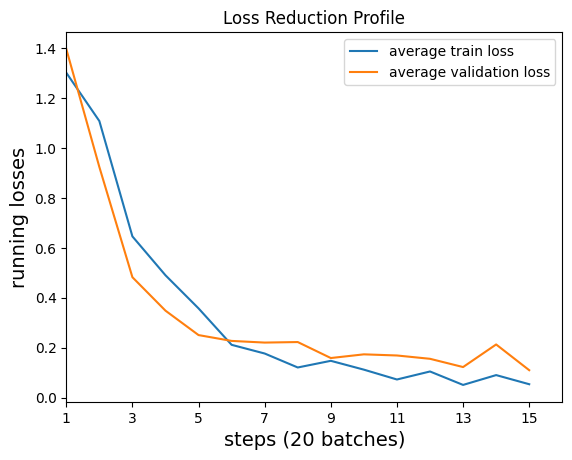

Plot saved as loss_profile.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Check and get the number of steps as the minimum length of the two lists
steps = len(running_val_loss)

# Ensure there is enough data to plot
if steps == 0:
    print("No data to plot. Please check your training process.")
else:
    # Plot the loss reduction graph
    plt.plot(np.arange(1, steps + 1), running_train_loss[:steps], label='average train loss')
    plt.plot(np.arange(1, steps + 1), running_val_loss[:steps], label='average validation loss')
    plt.xticks(range(1, steps + 1, 2))
    plt.xlim(1, steps + 1)
    plt.xlabel('steps (20 batches)')
    plt.ylabel('running losses')
    plt.title('Loss Reduction Profile')
    plt.legend(loc='upper right')

    # Save and display the plot
    filename = 'loss_profile.png'
    plt.savefig(filename)
    plt.show()
    print(f"Plot saved as {filename}")


#__12.__ Final result

In [ ]:
# load the saved model
save_file = './models/resnet18.pt'
if torch.cuda.is_available():
    model.load_state_dict(torch.load(save_file))
else:
    model.load_state_dict(torch.load(save_file, map_location=torch.device('cpu')))

<ipython-input-32-183158a9111e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_file))


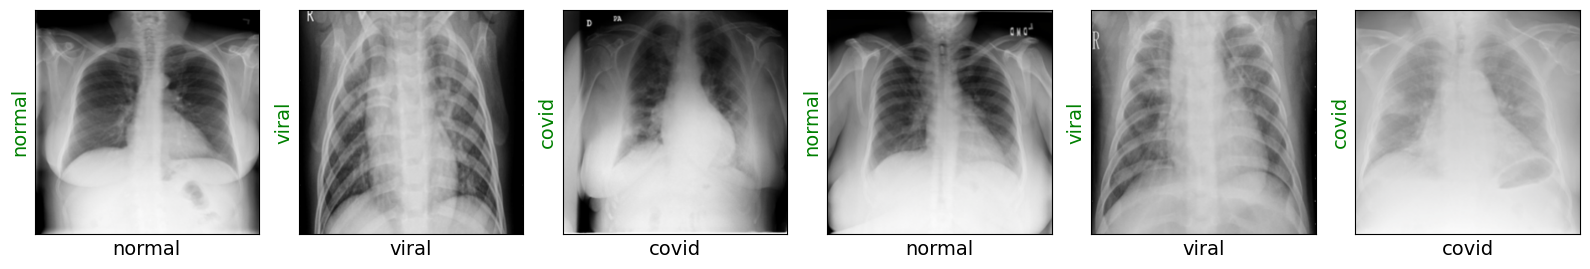

In [ ]:
show_preds()

In [ ]:
# Calculate accuracy by class
print('calculating model accuracy after training....')
num_classes = len(class_names)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()
for val_step, (images, labels) in enumerate(dl_test):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)

    correct_tensor = preds.eq(labels.view_as(preds))    # equivalent to tensor.view(preds.size())
    correct = np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for i in range(num_classes):
    if class_total[i] > 0:

        print('Test Accuracy on {}:'.format(class_names[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(10,' '),
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))

    else:
        print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))

print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(25),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(5))


calculating model accuracy after training....
Test Accuracy on normal:  94%       (30/32)
Test Accuracy on viral:  96%       (25/26)
Test Accuracy on covid:  100%      (32/32)

Test Accuracy (Overall):  97%      (87/90)


#__13.__ Inference on single image

<ipython-input-36-29340caec066>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Predicted class: normal


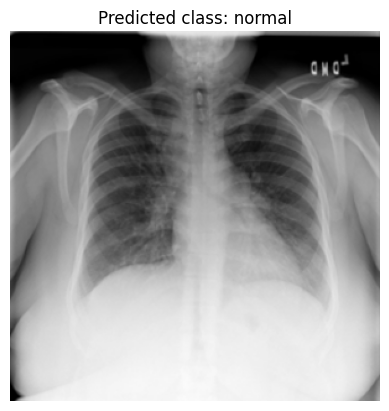

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the class names based on the problem setup
class_names = ['normal', 'viral', 'covid']

# Load the trained model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(in_features=512, out_features=3)  # Adjust output layer to 3 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the saved model weights
model_path = './models/resnet18.pt'  # Ensure this path is correct in your Colab environment
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

# Define the image transformations: same as those used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Function to run inference on a single image
def infer_single_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format
    image_tensor = transform(image).unsqueeze(0).to(device)  # Transform and add batch dimension

    # Run the model on the image
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class label
    predicted_class = class_names[predicted.item()]
    print(f'Predicted class: {predicted_class}')

    # Display the image using matplotlib
    plt.imshow(np.array(image))
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Assuming you upload one image, get the first uploaded file's path
image_path = '/content/COVID-19_Radiography_Dataset/test/normal/Normal-1896.png'  # Takes the first uploaded image path
infer_single_image(image_path)
